## Goal

Here we want to know the parameter range, including 

1. The distance between a pair of atoms
2. The maximum of Omega
3. The maximum of abs value of Delta
4. The slew rate of Omega, Delta, and phi

that the local simulator can give reasonable result. And we will investigate what to suggest to customers if they want to go out of the range. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import time


from braket.ahs.hamiltonian import Hamiltonian
from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

from braket.timings.time_series import TimeSeries
from braket.ahs.driving_field import DrivingField

from braket.devices import LocalSimulator
device = LocalSimulator("braket_ahs")

from pprint import pprint as pp

def get_counters_from_result(result):
    post_sequences = [list(measurement.post_sequence) for measurement in result.measurements]
    post_sequences = ["".join(['r' if site==0 else 'g' for site in post_sequence]) for post_sequence in post_sequences]

    counters = {}
    for post_sequence in post_sequences:
        if post_sequence in counters:
            counters[post_sequence] += 1
        else:
            counters[post_sequence] = 1
    return counters


In [2]:
num1 = 10 # number of data points for Omega

Omega_slew_range = np.linspace(10, 300, num1) * 1e12 # The range of Omega


t_max = 4e-6 # We fix the duration of the program
C6 = 5.42e-24 # The interaction coefficient
# shots = 10_000 # We fix the number of shots
shots = 100 # We fix the number of shots
steps = 100 # For time steps
nsteps = 1000 # For scipy
epsilon = 0.01 # threshold for the discrepancy of local sim and theory result

def Rb(Omega, Delta):
    return (C6/np.sqrt(Omega**2 + Delta**2))**(1/6)

In [3]:
def compare(programs, steps = steps, shots = shots, nsteps=nsteps):


    results_sim = {}
    results_theory = {}
    diff = {}

    total_time = 0
    for key, program in programs.items():
        
        start_time = time.time()                
        try:
            result = device.run(program, steps = steps, shots = shots, nsteps=nsteps).result()
        except:
            print(f"Error for {key}")
            continue
        
        total_time += time.time() - start_time        

        print(f"Result got for {key}")
        result_sim_temp = get_counters_from_result(result)
        
        results_sim[key] = {'g': 0, 'r': 0}
        
        
        num_atoms = int(len(list(result_sim_temp.keys())[0]))
                
        for key2, val2 in result_sim_temp.items():
            for i in range(num_atoms):
                results_sim[key][key2[i]] += val2

        # Get the theory result
        values = programs[key].hamiltonian.amplitude.time_series.values()
        Omega_area = values[1] * t_max/2
        g_theory = round(np.cos(Omega_area/2)**2 * shots*num_atoms)
        r_theory = round(np.sin(Omega_area/2)**2 * shots*num_atoms)
        
        
        results_theory[key] = {
            'g': g_theory,
            'r': r_theory
        }

        diff[key] = {}

        
        for state in ['g', 'r']:
            diff[key][state] = abs(results_theory[key][state]-results_sim[key][state])/(shots*num_atoms)
            
    # average runtime per program
    avg_time = total_time/len(programs)                        
    return results_sim, results_theory, diff, avg_time


def visualize_diff(diff, state="g"):
    
    plt.plot(list(diff.keys()), [item[state]*100 for item in list(diff.values())], 'o-')
    plt.xlabel("Omega slew rate (Hz)")
    plt.ylabel("differece in percentage")    
    
    

## Task 5: Triangular Omega pulses for a pair of atoms
This is for testing the robustness of the scipy solver


## Conclusion

1. With default parameters, the error rate could be as worst as 1.6%!

2. Increasing the number of `steps` will lead to some failures! The successful runs have error rate 0.02%

3. Increasing the `nsteps` by 10 times does not change the result



In [4]:
programs = {}
a = 1e-4
for Omega_slew in Omega_slew_range:
        
    register = AtomArrangement()
    
    for i in range(10):
        register.add([0, i*a])

    Omega_global = TimeSeries()
    Omega_global.put(0.0, 0).put(t_max/2, Omega_slew * t_max/2).put(t_max, 0)
    
    # e.g. all-zero phase and detuning
    phi = TimeSeries().put(0.0, 0.0).put(t_max, 0.0)  # (time [s], value [rad])
    Delta_global = TimeSeries().put(0.0, 0.0).put(t_max, 0.0)  # (time [s], value [rad/s])

    drive = DrivingField(
        amplitude=Omega_global,
        phase=phi,
        detuning=Delta_global
    )            

    program = AnalogHamiltonianSimulation(
        hamiltonian=drive,
        register=register
    )

    programs[Omega_slew] = program


In [5]:
# programs

In [6]:
results_sim, results_theory, diff, avg_time = compare(programs)

/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/atom_arrangement.py:69: UserWarning: Arrangement is too tall. Sites [Decimal('0'), Decimal('0.0')] and [Decimal('0'), Decimal('0.0009000000000000001')] have y-separation bigger than the typical scale (0.0001 meters). The coordinates of the atoms should be specified in SI units.
  warnings.warn(


Result got for 10000000000000.0


/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/field_validator_util.py:22: UserWarning: Value 1 (84444444.44444443) in amplitude time series outside the typical range [0, 25000000.0]. The values should  be specified in SI units.
  warnings.warn(


Result got for 42222222222222.22


/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/field_validator_util.py:22: UserWarning: Value 1 (148888888.88888887) in amplitude time series outside the typical range [0, 25000000.0]. The values should  be specified in SI units.
  warnings.warn(


Result got for 74444444444444.44


/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/field_validator_util.py:22: UserWarning: Value 1 (213333333.3333333) in amplitude time series outside the typical range [0, 25000000.0]. The values should  be specified in SI units.
  warnings.warn(


Result got for 106666666666666.66


/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/field_validator_util.py:22: UserWarning: Value 1 (277777777.7777778) in amplitude time series outside the typical range [0, 25000000.0]. The values should  be specified in SI units.
  warnings.warn(


Result got for 138888888888888.89


/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/field_validator_util.py:22: UserWarning: Value 1 (342222222.2222222) in amplitude time series outside the typical range [0, 25000000.0]. The values should  be specified in SI units.
  warnings.warn(


Result got for 171111111111111.12


/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/field_validator_util.py:22: UserWarning: Value 1 (406666666.6666666) in amplitude time series outside the typical range [0, 25000000.0]. The values should  be specified in SI units.
  warnings.warn(


Result got for 203333333333333.3


/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/field_validator_util.py:22: UserWarning: Value 1 (471111111.11111104) in amplitude time series outside the typical range [0, 25000000.0]. The values should  be specified in SI units.
  warnings.warn(


Result got for 235555555555555.53


/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/field_validator_util.py:22: UserWarning: Value 1 (535555555.5555555) in amplitude time series outside the typical range [0, 25000000.0]. The values should  be specified in SI units.
  warnings.warn(


Result got for 267777777777777.78


/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/field_validator_util.py:22: UserWarning: Value 1 (600000000.0) in amplitude time series outside the typical range [0, 25000000.0]. The values should  be specified in SI units.
  warnings.warn(


Result got for 300000000000000.0


In [7]:
print(f"The average runtime per program = {avg_time} seconds")

The average runtime per program = 26.9679603099823 seconds


In [8]:
results_sim

{10000000000000.0: {'g': 16899, 'r': 83101},
 42222222222222.22: {'g': 85766, 'r': 14234},
 74444444444444.44: {'g': 11948, 'r': 88052},
 106666666666666.66: {'g': 90338, 'r': 9662},
 138888888888888.89: {'g': 7777, 'r': 92223},
 171111111111111.12: {'g': 94151, 'r': 5849},
 203333333333333.3: {'g': 4476, 'r': 95524},
 235555555555555.53: {'g': 96920, 'r': 3080},
 267777777777777.78: {'g': 1921, 'r': 98079},
 300000000000000.0: {'g': 98877, 'r': 1123}}

In [9]:
results_theory

{10000000000000.0: {'g': 16653, 'r': 83347},
 42222222222222.22: {'g': 86341, 'r': 13659},
 74444444444444.44: {'g': 10919, 'r': 89081},
 106666666666666.66: {'g': 91549, 'r': 8451},
 138888888888888.89: {'g': 6274, 'r': 93726},
 171111111111111.12: {'g': 95598, 'r': 4402},
 203333333333333.3: {'g': 2848, 'r': 97152},
 235555555555555.53: {'g': 98376, 'r': 1624},
 267777777777777.78: {'g': 738, 'r': 99262},
 300000000000000.0: {'g': 99805, 'r': 195}}

In [10]:
diff

{10000000000000.0: {'g': 0.00246, 'r': 0.00246},
 42222222222222.22: {'g': 0.00575, 'r': 0.00575},
 74444444444444.44: {'g': 0.01029, 'r': 0.01029},
 106666666666666.66: {'g': 0.01211, 'r': 0.01211},
 138888888888888.89: {'g': 0.01503, 'r': 0.01503},
 171111111111111.12: {'g': 0.01447, 'r': 0.01447},
 203333333333333.3: {'g': 0.01628, 'r': 0.01628},
 235555555555555.53: {'g': 0.01456, 'r': 0.01456},
 267777777777777.78: {'g': 0.01183, 'r': 0.01183},
 300000000000000.0: {'g': 0.00928, 'r': 0.00928}}

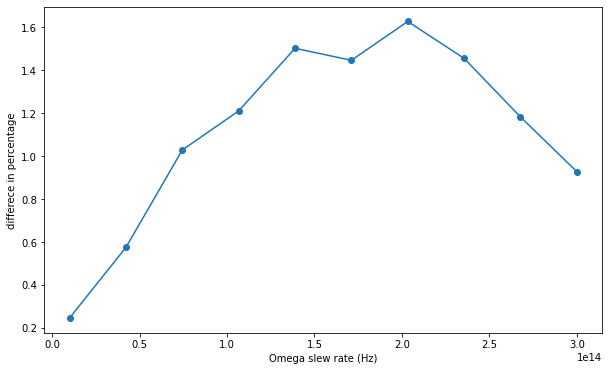

In [11]:
plt.rcParams["figure.figsize"] = (10,6)
visualize_diff(diff)

### Rerun with larger number of time steps

In [12]:
results_sim, results_theory, diff, avg_time = compare(programs, steps = 10 * steps)

Error for 10000000000000.0


capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.


Error for 42222222222222.22


capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.


Error for 74444444444444.44
Error for 106666666666666.66


capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.


Error for 138888888888888.89


capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.


Result got for 171111111111111.12
Error for 203333333333333.3


capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.


Error for 235555555555555.53
Result got for 267777777777777.78
Result got for 300000000000000.0


In [13]:
print(f"The average runtime per program = {avg_time} seconds")

The average runtime per program = 19.51727149486542 seconds


In [14]:
results_sim

{171111111111111.12: {'g': 95640, 'r': 4360},
 267777777777777.78: {'g': 705, 'r': 99295},
 300000000000000.0: {'g': 99812, 'r': 188}}

In [15]:
results_theory

{171111111111111.12: {'g': 95598, 'r': 4402},
 267777777777777.78: {'g': 738, 'r': 99262},
 300000000000000.0: {'g': 99805, 'r': 195}}

In [16]:
pp(diff)

{171111111111111.12: {'g': 0.00042, 'r': 0.00042},
 267777777777777.78: {'g': 0.00033, 'r': 0.00033},
 300000000000000.0: {'g': 7e-05, 'r': 7e-05}}


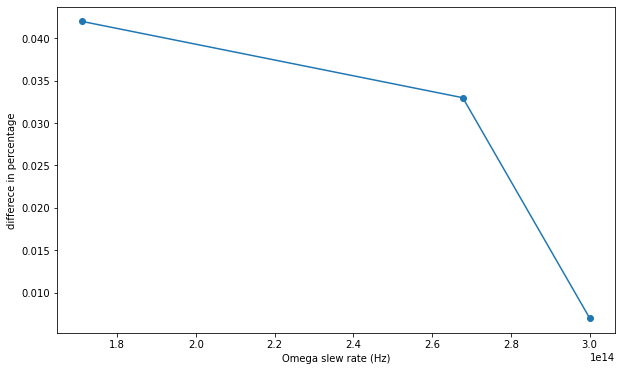

In [17]:
plt.rcParams["figure.figsize"] = (10,6)
visualize_diff(diff)

### Rerun with larger number of nsteps

In [18]:
results_sim, results_theory, diff, avg_time = compare(programs, nsteps = 10 * nsteps)

Result got for 10000000000000.0
Result got for 42222222222222.22
Result got for 74444444444444.44
Result got for 106666666666666.66
Result got for 138888888888888.89
Result got for 171111111111111.12
Result got for 203333333333333.3
Result got for 235555555555555.53
Result got for 267777777777777.78
Result got for 300000000000000.0


In [19]:
print(f"The average runtime per program = {avg_time} seconds")

The average runtime per program = 27.025242424011232 seconds


In [20]:
pp(diff)

{10000000000000.0: {'g': 0.00187, 'r': 0.00187},
 42222222222222.22: {'g': 0.0052, 'r': 0.0052},
 74444444444444.44: {'g': 0.00976, 'r': 0.00976},
 106666666666666.66: {'g': 0.01243, 'r': 0.01243},
 138888888888888.89: {'g': 0.01332, 'r': 0.01332},
 171111111111111.12: {'g': 0.01444, 'r': 0.01444},
 203333333333333.3: {'g': 0.01419, 'r': 0.01419},
 235555555555555.53: {'g': 0.01476, 'r': 0.01476},
 267777777777777.78: {'g': 0.01188, 'r': 0.01188},
 300000000000000.0: {'g': 0.009, 'r': 0.009}}


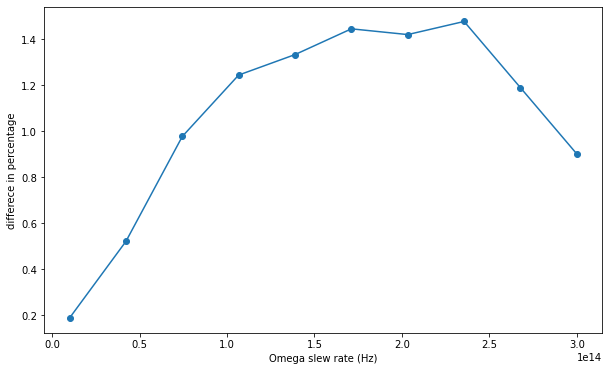

In [21]:
plt.rcParams["figure.figsize"] = (10,6)
visualize_diff(diff)